<a href="https://colab.research.google.com/github/anothergrind/music_while_reading/blob/main/CGS_3346_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Import modules for the project
import pandas as pd
import numpy as np
from scipy.stats import ttest_rel
import statsmodels.formula.api as smf
from statsmodels.formula.api import ols
import seaborn as sns
import matplotlib.pyplot as plt


In [ ]:
# Data Cleaning/Conditioning

# Read in the survey data from the class
df_survey = pd.read_csv(r'survey.csv')

# Survey dataframes for no music and music
df_no_music = df_survey[df_survey['Music'] == 'N']
df_music = df_survey[df_survey['Music'] == 'Y']

# Impute missing values for Opinion and Hungriness
def impute_opinion_demographics(df, demo_cols):
    df = df.copy()
    for name, group in df.groupby('Name'):
        missing_idx = group[group['Opinion'].isna()].index
        for idx in missing_idx:
            row = df.loc[idx]
            # Filter all other students in same condition (Music)
            candidates = df[
                (df['Music'] == row['Music']) &
                (df['Name'] != row['Name'])
            ]
            # Further filter by demographics
            for col in demo_cols:
                candidates = candidates[candidates[col] == row[col]]

            # Use observed Opinion values
            observed_op = candidates['Opinion'].dropna()
            if len(observed_op) > 0:
                df.loc[idx, 'Opinion'] = np.random.choice(observed_op)
            else:
                # Fallback: sample from all in same Music condition
                observed_op = df[df['Music'] == row['Music']]['Opinion'].dropna()
                df.loc[idx, 'Opinion'] = np.random.choice(observed_op)

            # Use observed Hungriness values
            observed_h = candidates['Hungriness'].dropna()
            if len(observed_h) > 0:
                df.loc[idx, 'Hungriness'] = np.random.choice(observed_h)
            else:
                observed_h = df[df['Music'] == row['Music']]['Hungriness'].dropna()
                df.loc[idx, 'Hungriness'] = np.random.choice(observed_h)

    return df

In [ ]:
cols = ['Age', 'Gender', 'Major', 'Year']
df_survey_imp = impute_opinion_demographics(df_survey, cols)
df_survey_imp

,Name,Age,Gender,Major,Year,Hungriness,Music,Opinion
0,Nicholas,19,M,Y,Junior,6.0,N,4.0
1,Nicholas,19,M,Y,Junior,3.0,Y,4.0
2,Selugi,20,F,Y,Junior,4.0,N,6.0
3,Selugi,20,F,Y,Junior,7.0,Y,1.0
4,Aditi,19,F,Y,Sophomore,4.0,N,3.0
5,Aditi,19,F,Y,Sophomore,6.0,Y,1.0
6,Madhu,19,F,Y,Sophomore,7.0,N,2.0
7,Madhu,19,F,Y,Sophomore,6.0,Y,1.0
8,Karen,24,F,Y,Junior,2.0,N,4.0
9,Karen,24,F,Y,Junior,7.0,Y,4.0


In [ ]:
# Matched Pairs T-Test

# Convert the dataframe to wide format
df_wide = df_survey_imp.pivot(index = 'Name', columns = 'Music', values = 'Opinion').reset_index()
df_wide.rename(columns={'N':'Opinion_no', 'Y':'Opinion_yes'}, inplace=True)

# Calculate the differences with and without music
df_wide['D'] = df_wide['Opinion_yes'] - df_wide['Opinion_no']

# Display the differences in opinion
print(df_wide[['Name','Opinion_no','Opinion_yes','D']])

# Run a paired t-test
t_stat, p_value = ttest_rel(df_wide['Opinion_yes'], df_wide['Opinion_no'])
print(f"Paired t-test results:\nt = {t_stat:.3f}, p = {p_value:.3f}")

# Determine statistical significance
if p_value < 0.05:
    print("Significant difference in opinions with vs. without music (reject H0)")
else:
    print("No significant difference in opinions (fail to reject H0)")

Music      Name  Opinion_no  Opinion_yes    D
0         Aditi         3.0          1.0 -2.0
1         Danat         4.0          4.0  0.0
2         Darsh         7.0          5.0 -2.0
3         Karen         4.0          4.0  0.0
4         Leina         4.0          1.0 -3.0
5         Madhu         2.0          1.0 -1.0
6       Mridini         1.0          1.0  0.0
7      Nicholas         4.0          4.0  0.0
8       Rebecca         2.0          1.0 -1.0
9         Reham         4.0          1.0 -3.0
10       Sakshi         4.0          4.0  0.0
11       Selugi         6.0          1.0 -5.0
12        Vipha         2.0          1.0 -1.0
13         Zora         6.0          1.0 -5.0
Paired t-test results:
t = -3.452, p = 0.004
Significant difference in opinions with vs. without music (reject H0)


In [ ]:
# Create a mixed effects model
df_mixed = df_survey_imp.copy()

# Convert columns to binary and dummy encode
df_mixed["Music"] = df_mixed["Music"].map({"N":0,"Y":1})
df_mixed["Gender"] = df_mixed["Gender"].map({"M":0,"F":1})
df_mixed["Major"] = df_mixed["Major"].map({"N":0,"Y":1})
df_mixed = pd.get_dummies(df_mixed, columns=["Year"], drop_first=True)

# Drop the name and age columns
df_mixed = df_mixed.drop(['Age'], axis=1)

model = smf.mixedlm(
    "Opinion ~ Music + Gender + Major + Hungriness + Year_Sophomore + Year_Senior",
    df_mixed,
    groups=df_mixed["Name"]  # keep Name here!
)
result = model.fit()
print(result.summary())

              Mixed Linear Model Regression Results
Model:                 MixedLM    Dependent Variable:    Opinion 
No. Observations:      28         Method:                REML    
No. Groups:            14         Scale:                 1.6335  
Min. group size:       2          Log-Likelihood:        -43.8786
Max. group size:       2          Converged:             Yes     
Mean group size:       2.0                                       
-----------------------------------------------------------------
                       Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------------------
Intercept               8.441    1.423  5.933 0.000  5.653 11.230
Year_Sophomore[T.True] -0.445    0.696 -0.640 0.522 -1.809  0.919
Year_Senior[T.True]    -0.339    0.775 -0.437 0.662 -1.858  1.180
Music                  -1.670    0.484 -3.452 0.001 -2.618 -0.722
Gender                 -2.546    0.856 -2.975 0.003 -4.223 -0.869
Major                  -

In [ ]:
major_y_opinion = df_survey_imp[df_survey_imp['Major'] == 'Y']['Opinion']
major_n_opinion = df_survey_imp[df_survey_imp['Major'] == 'N']['Opinion']

# Calculate quartiles for Major Y
q1_y = major_y_opinion.quantile(0.25)
q3_y = major_y_opinion.quantile(0.75)
iqr_y = q3_y - q1_y
upper_bound_y = q3_y + 1.5 * iqr_y
lower_bound_y = q1_y - 1.5 * iqr_y

print(f"--- Major Y Opinion ---")
print(f"Q1: {q1_y:.2f}")
print(f"Q3: {q3_y:.2f}")
print(f"IQR: {iqr_y:.2f}")
print(f"Upper outlier bound: {upper_bound_y:.2f}")
print(f"Lower outlier bound: {lower_bound_y:.2f}")

# Calculate quartiles for Major N
q1_n = major_n_opinion.quantile(0.25)
q3_n = major_n_opinion.quantile(0.75)
iqr_n = q3_n - q1_n
upper_bound_n = q3_n + 1.5 * iqr_n
lower_bound_n = q1_n - 1.5 * iqr_n

print(f"\n--- Major N Opinion ---")
print(f"Q1: {q1_n:.2f}")
print(f"Q3: {q3_n:.2f}")
print(f"IQR: {iqr_n:.2f}")
print(f"Upper outlier bound: {upper_bound_n:.2f}")
print(f"Lower outlier bound: {lower_bound_n:.2f}")

# Check for actual outliers
outliers_y = major_y_opinion[(major_y_opinion > upper_bound_y) | (major_y_opinion < lower_bound_y)]
outliers_n = major_n_opinion[(major_n_opinion > upper_bound_n) | (major_n_opinion < lower_bound_n)]

print(f"\nOutliers for Major Y: {list(outliers_y.values)}")
print(f"Outliers for Major N: {list(outliers_n.values)}")

--- Major Y Opinion ---
Q1: 1.00
Q3: 4.00
IQR: 3.00
Upper outlier bound: 8.50
Lower outlier bound: -3.50

--- Major N Opinion ---
Q1: 4.00
Q3: 4.00
IQR: 0.00
Upper outlier bound: 4.00
Lower outlier bound: 4.00

Outliers for Major Y: []
Outliers for Major N: []


In [ ]:
# Confidence Interval (95%, Paired T Test)
paired_t_test = []
B = 2000
N = len(df_wide)

for i in range(B):
  sample = df_wide['D'].sample(N, replace=True)
  M_D = np.mean(sample)
  paired_t_test.append(M_D)

LL_D = np.quantile(paired_t_test, 0.025)
UL_D = np.quantile(paired_t_test, 0.975)

print(f"95% Confidence Interval for Mean Difference (D):\nLower Bound (LL_D) = {LL_D:.2f}\nUpper Bound (UL_D) = {UL_D:.2f}")

95% Confidence Interval for Mean Difference (D):
Lower Bound (LL_D) = -2.57
Upper Bound (UL_D) = -0.79


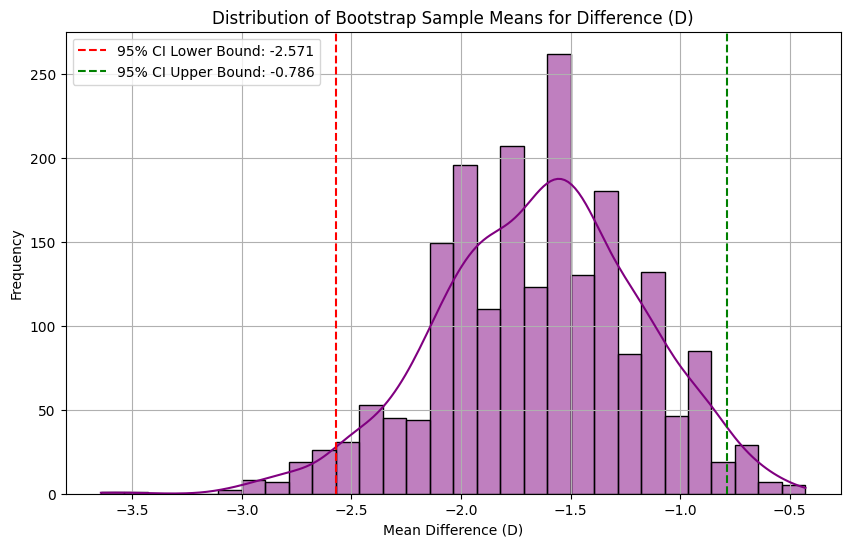

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(paired_t_test, kde=True, color='purple', bins=30)
plt.axvline(LL_D, color='red', linestyle='--', label=f'95% CI Lower Bound: {LL_D:.3f}')
plt.axvline(UL_D, color='green', linestyle='--', label=f'95% CI Upper Bound: {UL_D:.3f}')
plt.title('Distribution of Bootstrap Sample Means for Difference (D)')
plt.xlabel('Mean Difference (D)')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.show()

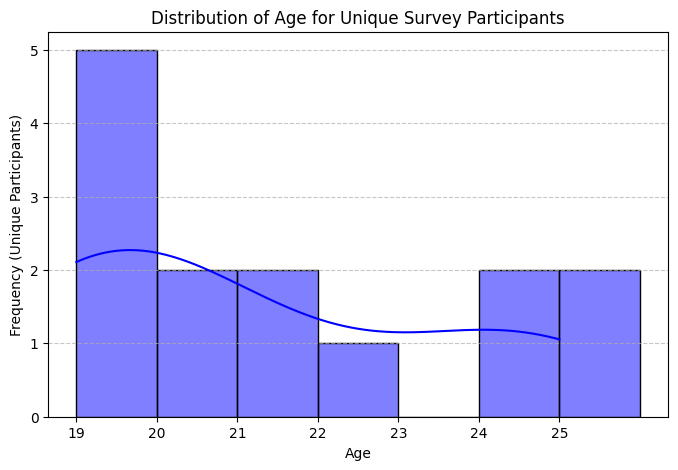

In [ ]:
# Create a DataFrame with unique participants for demographics
df_unique_participants = df_survey_imp.drop_duplicates(subset=['Name']).copy()

plt.figure(figsize=(8, 5))
sns.histplot(df_unique_participants['Age'], kde=True, bins=range(min(df_unique_participants['Age']), max(df_unique_participants['Age']) + 2), color='blue')
plt.title('Distribution of Age')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.xticks(range(min(df_unique_participants['Age']), max(df_unique_participants['Age']) + 1))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

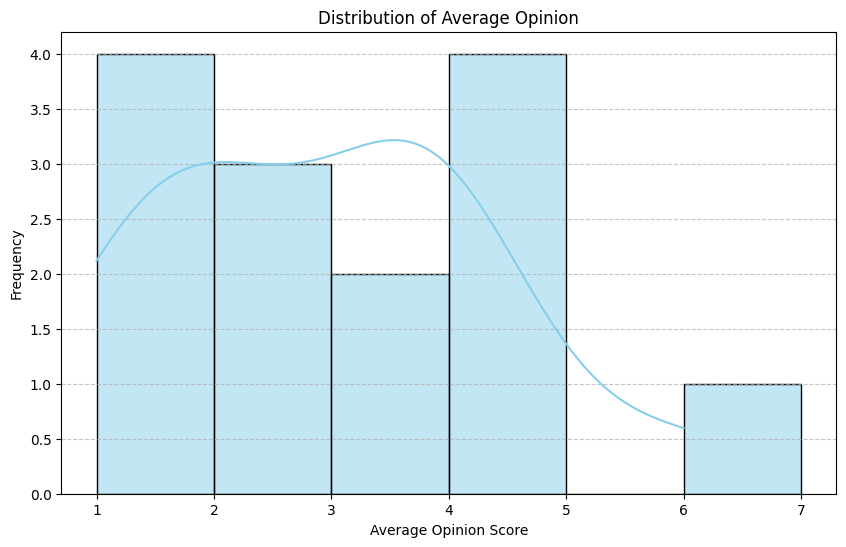

In [ ]:
# Prepare data for Opinion and Hungriness distributions based on average per participant
# Calculate average Opinion per participant
opinion_avg_per_participant = df_wide[['Opinion_no', 'Opinion_yes']].mean(axis=1)

# Prepare df_wide for Hungriness
df_wide_hungriness = df_survey_imp.pivot(index = 'Name', columns = 'Music', values = 'Hungriness').reset_index()
df_wide_hungriness.rename(columns={'N':'Hungriness_no', 'Y':'Hungriness_yes'}, inplace=True)

# Calculate average Hungriness per participant
hungriness_avg_per_participant = df_wide_hungriness[['Hungriness_no', 'Hungriness_yes']].mean(axis=1)

# Distribution of Average Opinion per Participant
plt.figure(figsize=(10, 6))
sns.histplot(opinion_avg_per_participant, kde=True, color='skyblue', bins=range(int(opinion_avg_per_participant.min()), int(opinion_avg_per_participant.max()) + 2))
plt.title('Distribution of Average Opinion')
plt.xlabel('Average Opinion Score')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [ ]:
# Bootstrap (Hungriness) - Removed as per user request to not use bootstrap.
# Calculations for average hungriness per participant are performed in a separate cell before plotting.

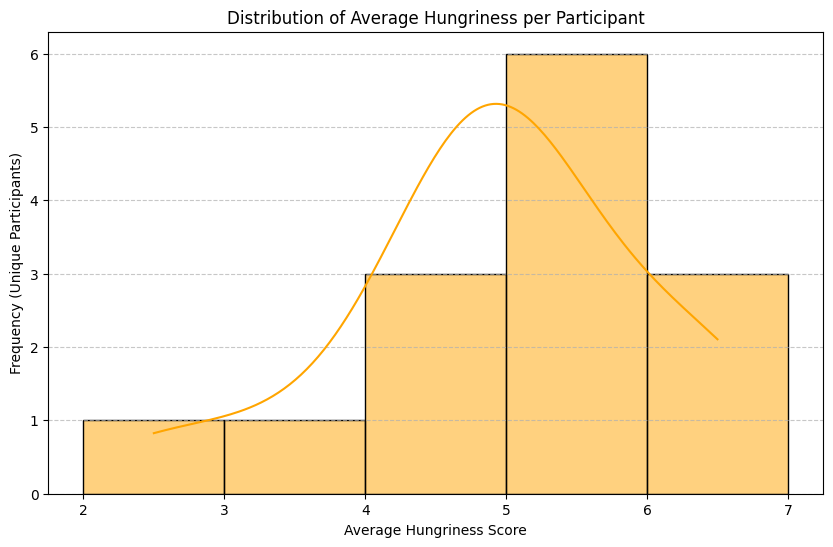

In [ ]:
# Distribution of Average Hungriness per Participant
plt.figure(figsize=(10, 6))
sns.histplot(hungriness_avg_per_participant, kde=True, color='orange', bins=range(int(hungriness_avg_per_participant.min()), int(hungriness_avg_per_participant.max()) + 2))
plt.title('Distribution of Average Hungriness')
plt.xlabel('Average Hungriness Score')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()